# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

In [164]:
from statsmodels.tsa.seasonal import seasonal_decompose

import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.inspection import permutation_importance
from sklearn.pipeline import Pipeline

The title itself provides the business ubderstanding of the car, For the Dealership:
Understanding which specific car features—such as make, model, or paint color—are most popular allows the dealership to optimize its inventory. For a national chain, this analysis can also reveal if regional preferences influence buying trends, helping them tailor stock to local markets.

For the Sales Team:
By knowing which car attributes are most desirable, salespeople can negotiate more effectively, structure appealing deals, and determine optimal final offers. This insight also helps them identify the most in-demand cars on the lot.

Success and Revenue Goals:
A key measure of success would be to pinpoint the  most significant features that influence a car's price. By doing so, the dealership can focus on acquiring more of these high-value vehicles. This information also enables them to create a strategic pricing and discount plan that maximizes overall earnings for the business.

We will use following  Exploration Steps :

a)identify columns, possible values, min, max and missing values etc
b)Remove data set around missed values, another option is to adjust but for simplicity we will just remove
c)Transformation of categorical columns using encoder
d)Identify relationships between columns by using correlations
e)Explore the importance of each column with the price

In [95]:
import warnings
warnings.filterwarnings("ignore")

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

The steps to take to describe the data include the following
1. read the data from vehicles.csv
2. Get the information  about the columns in the data
3. Use describe to get basic stats for the data for numerical columns including id, price, year, odometer.
4. Under the categorical data

In [ ]:
# Decribing the data that has been provided using Pandas functions
df = pd.read_csv('data/vehicles.csv')
df.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [97]:
#Get the information  about the columns in the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [98]:
# Get stats for the data
df.describe()

,id,price,year,odometer
count,4.268800e+05,4.268800e+05,425675.000000,4.224800e+05
mean,7.311487e+09,7.519903e+04,2011.235191,9.804333e+04
std,4.473170e+06,1.218228e+07,9.452120,2.138815e+05
min,7.207408e+09,0.000000e+00,1900.000000,0.000000e+00
25%,7.308143e+09,5.900000e+03,2008.000000,3.770400e+04
50%,7.312621e+09,1.395000e+04,2013.000000,8.554800e+04
75%,7.315254e+09,2.648575e+04,2017.000000,1.335425e+05
max,7.317101e+09,3.736929e+09,2022.000000,1.000000e+07


In [99]:
# Lets find any duplicates, no duplicates found
df.duplicated().sum()

np.int64(0)

In [100]:
#Lets find missing values sum
df.isna().sum()

,0
id,0
region,0
price,0
year,1205
manufacturer,17646
model,5277
condition,174104
cylinders,177678
fuel,3013
odometer,4400


In [102]:
#Lets find missing values and see what percentage of them are in each column
print("Missing values in percentage")
df.isna().mean().sort_values(ascending=False)*100

Missing values in percentage


,0
size,71.767476
cylinders,41.622470
condition,40.785232
VIN,37.725356
drive,30.586347
paint_color,30.501078
type,21.752717
manufacturer,4.133714
title_status,1.930753
model,1.236179


In [103]:
# Lets see  unique values categorical columns
for column in ['region', 'manufacturer', 'condition', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']:
    print(f"\n Column '{column}' unique values are")
    print(df[column].unique())


 Column 'region' unique values are
['prescott' 'fayetteville' 'florida keys' 'worcester / central MA'
 'greensboro' 'hudson valley' 'medford-ashland' 'erie' 'el paso'
 'bellingham' 'skagit / island / SJI' 'la crosse' 'auburn' 'birmingham'
 'dothan' 'florence / muscle shoals' 'gadsden-anniston'
 'huntsville / decatur' 'mobile' 'montgomery' 'tuscaloosa'
 'anchorage / mat-su' 'fairbanks' 'kenai peninsula' 'southeast alaska'
 'flagstaff / sedona' 'mohave county' 'phoenix' 'show low' 'sierra vista'
 'tucson' 'yuma' 'fort smith' 'jonesboro' 'little rock' 'texarkana'
 'bakersfield' 'chico' 'fresno / madera' 'gold country' 'hanford-corcoran'
 'humboldt county' 'imperial county' 'inland empire' 'los angeles'
 'mendocino county' 'merced' 'modesto' 'monterey bay' 'orange county'
 'palm springs' 'redding' 'reno / tahoe' 'sacramento' 'san diego'
 'san luis obispo' 'santa barbara' 'santa maria' 'SF bay area'
 'siskiyou county' 'stockton' 'susanville' 'ventura county'
 'visalia-tulare' 'yuba-sutter'


Colums identification leads to following

**id**: Unique value, delete this column as it is not useful for regression
**region**: No harm delete , region within us is not an important factor for price of car
**price**: Sales price
**year**: Importat factor
**manufacturer**: Important factor
**model**: price may depend on model
**condition**: Cars Condition
**cylinders**: Too many missed records we can delete this
**fuel**:
**odometer**:Mileage of care
**title**:
**transmission**:
**VIN**: Unique # per car delete
**drive**: Too many missed records but is an important factor we can fill missed ones with "other"
**size**:306K of records missed, its a category column so we can fill with "other"
**type**: Many records missed fill with "other"
**paint_color**: Many records missed , fill with "other"
**state**: No records missed but not an important factor for prices


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

In [132]:
# Lets start data cleanup, stating with price
df_clean = df.query('price > 0')
df_clean.head()

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
0,7222695916,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az
1,7218891961,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar
2,7221797935,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl
3,7222270760,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma
4,7210384030,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc


In [133]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 393985 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            393985 non-null  int64  
 1   region        393985 non-null  object 
 2   price         393985 non-null  int64  
 3   year          392812 non-null  float64
 4   manufacturer  377800 non-null  object 
 5   model         389284 non-null  object 
 6   condition     242596 non-null  object 
 7   cylinders     233575 non-null  object 
 8   fuel          391391 non-null  object 
 9   odometer      391695 non-null  float64
 10  title_status  386251 non-null  object 
 11  transmission  392162 non-null  object 
 12  VIN           241827 non-null  object 
 13  drive         273731 non-null  object 
 14  size          111052 non-null  object 
 15  type          308053 non-null  object 
 16  paint_color   276836 non-null  object 
 17  state         393985 non-null  object 
dtypes: float6

In [134]:
# Drop the following columns, as these columns doesn't add lead to price information
df_clean.drop('id', axis=1, inplace=True)
df_clean.drop('VIN', axis=1, inplace=True)
df_clean.drop('region', axis=1, inplace=True)
df_clean.drop('state', axis=1, inplace=True)
df_clean.drop('size', axis=1, inplace=True)
df_clean.drop('paint_color', axis=1, inplace=True)
df_clean.drop('drive', axis=1, inplace=True)

In [108]:
df_clean.shape

(393985, 14)

In [136]:
# Lets check null values first
df_clean.isna().sum()

,0
price,0
year,1173
manufacturer,16185
model,4701
condition,151389
cylinders,160410
fuel,2594
odometer,2290
title_status,7734
transmission,1823


In [137]:
# There seem to be no null values, so lets do some info on this data
df_clean.info()


<class 'pandas.core.frame.DataFrame'>
Index: 393985 entries, 0 to 426879
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         393985 non-null  int64  
 1   year          392812 non-null  float64
 2   manufacturer  377800 non-null  object 
 3   model         389284 non-null  object 
 4   condition     242596 non-null  object 
 5   cylinders     233575 non-null  object 
 6   fuel          391391 non-null  object 
 7   odometer      391695 non-null  float64
 8   title_status  386251 non-null  object 
 9   transmission  392162 non-null  object 
 10  type          308053 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 36.1+ MB


In [138]:
# Lets do price describe
df_clean['price'].describe()

,price
count,3.939850e+05
mean,8.147763e+04
std,1.268064e+07
min,1.000000e+00
25%,7.000000e+03
50%,1.500000e+04
75%,2.759000e+04
max,3.736929e+09


In [139]:
# Although the IQR range for price is very large but we can drop cars price above 350000
df_clean = df_clean[(df_clean['price'] >= 1) & (df_clean['price'] <= 350_000)]
df_clean.shape

(393913, 11)

In [140]:
#Lets do odometer describe
df_clean['odometer'].describe()

,odometer
count,3.916230e+05
mean,9.869123e+04
std,2.052973e+05
min,0.000000e+00
25%,3.800000e+04
50%,8.700000e+04
75%,1.353290e+05
max,1.000000e+07


In [141]:
# For odometer is very large but we can drop cars with odometer eq 0 greater than 400_000 (1.5 IQR)
df_clean = df_clean[(df_clean['odometer'] > 0) & (df_clean['odometer'] <= 400_0000_000)]
df_clean.shape

(390510, 11)

In [142]:
# Lets do year describe
df_clean['year'].describe()

,year
count,389411.000000
mean,2011.025559
std,9.569679
min,1900.000000
25%,2008.000000
50%,2013.000000
75%,2017.000000
max,2022.000000


In [143]:
# For reasonable year is 1940 onwards as cars older than 80 years are too old
df_clean = df_clean[(df_clean['year'] >= 1940) & (df_clean['year'] <= 2022)]
df_clean.shape

(388737, 11)

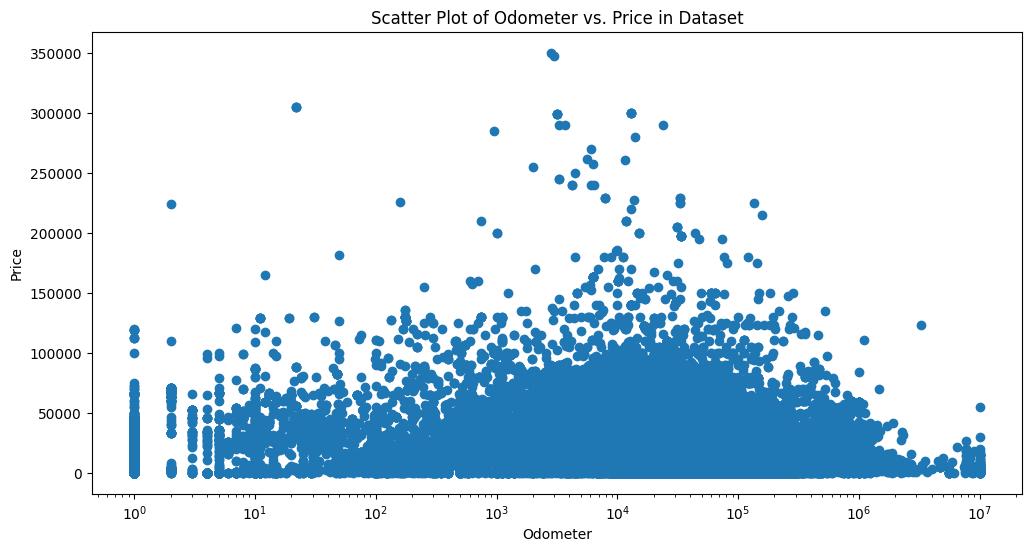

In [144]:
# Lets look at a scatter plot of the odometer and price to see the distribution of data
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(df_clean['odometer'], df_clean['price'])
plt.xscale("log")
ax.set_title('Scatter Plot of Odometer vs. Price in Dataset')
ax.set_xlabel('Odometer')
ax.set_ylabel('Price')
plt.show()

Text(0.5, 0, 'Year')

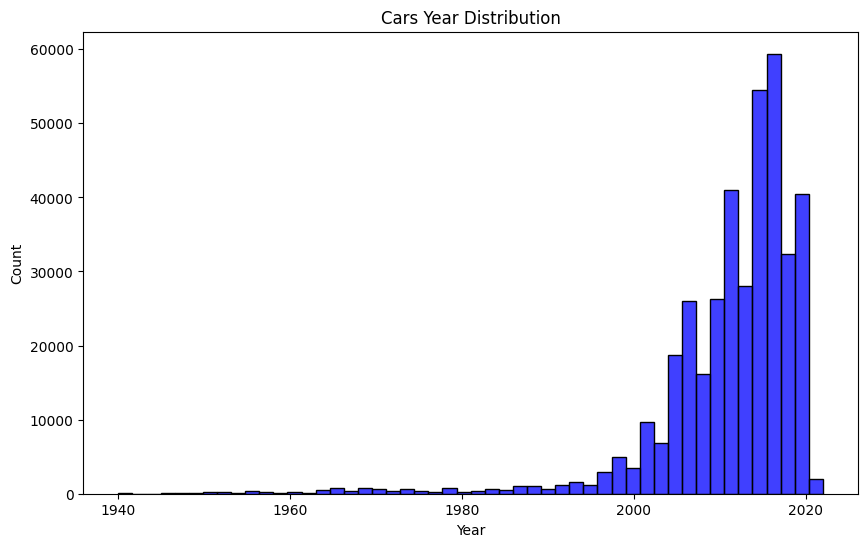

In [145]:
# Lets create a hostogram plot for calls by the year
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['year'], bins=50,  color='blue')
plt.title('Cars Year Distribution')
plt.xlabel('Year')


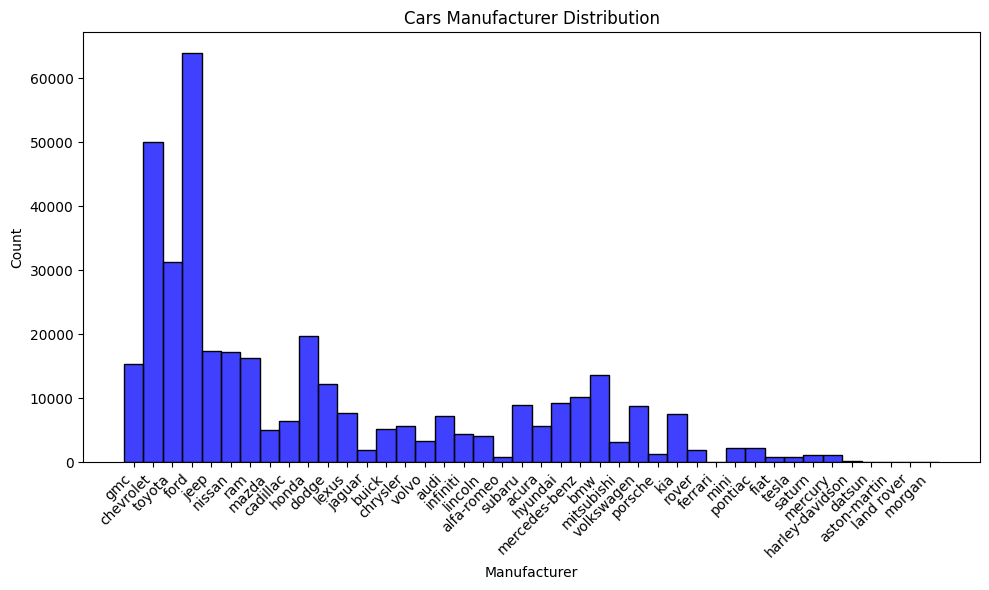

In [146]:
#Lets do a histogram plot of cars by manufacturer
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['manufacturer'], bins=50,  color='blue')
plt.title('Cars Manufacturer Distribution')
plt.xlabel('Manufacturer')
# Lets Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

Text(0.5, 0, 'Price')

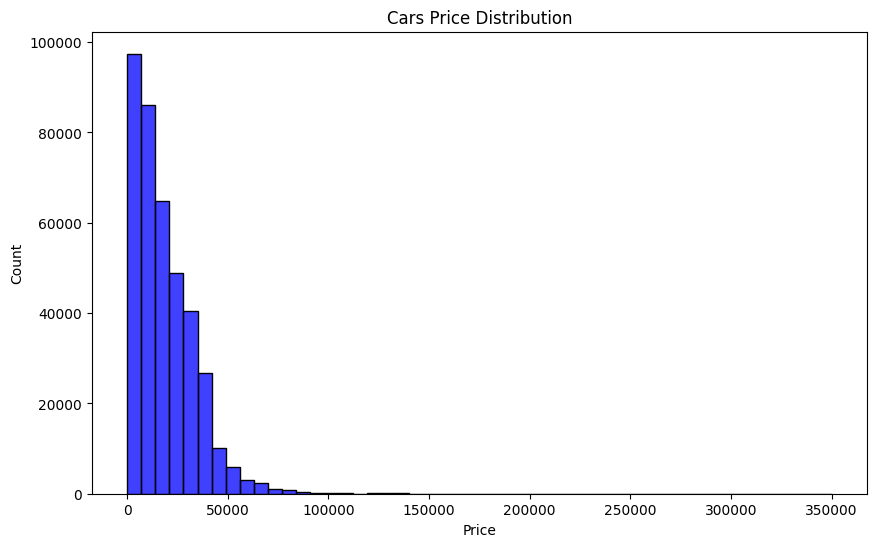

In [147]:
# lets do histogram plot of car prices and counts
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['price'], bins=50,  color='blue')
plt.title('Cars Price Distribution')
plt.xlabel('Price')

In [124]:
# Car prices are Right Skewed after the outlier removal as well

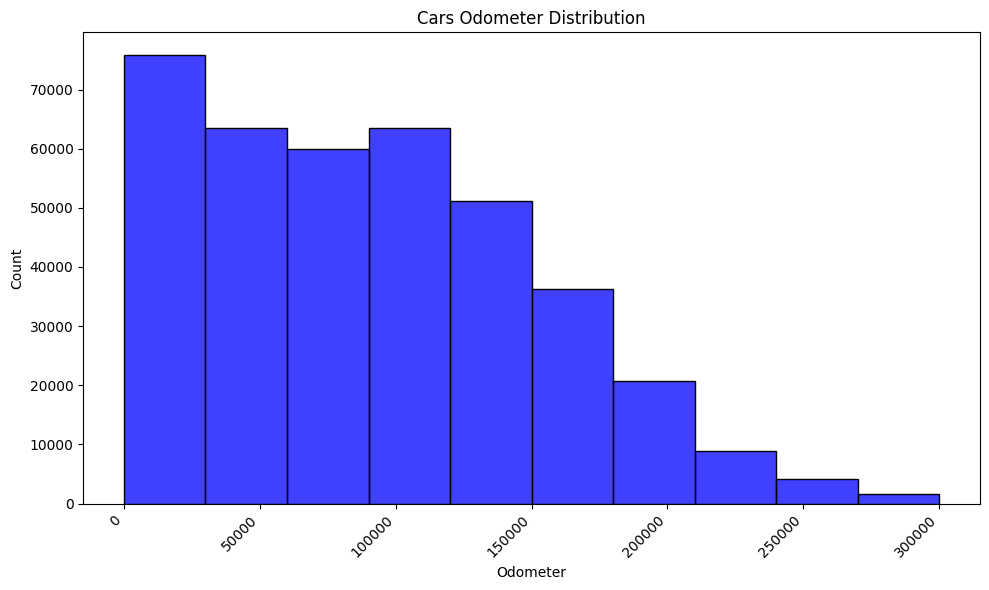

In [148]:
#lets do histogram plot of odometer
df_clean = df_clean[df_clean['odometer'] < 300000]
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['odometer'], bins=10,  color='blue')
plt.title('Cars Odometer Distribution')
plt.xlabel('Odometer')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()


In [149]:
#Odometer reading are little right Skewed

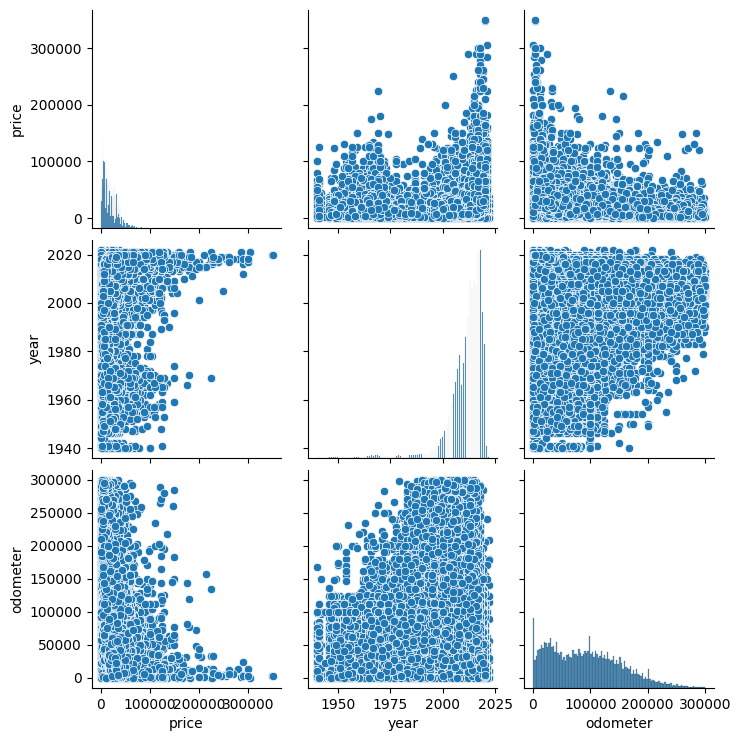

In [150]:
sns.pairplot(df_clean)

<Axes: >

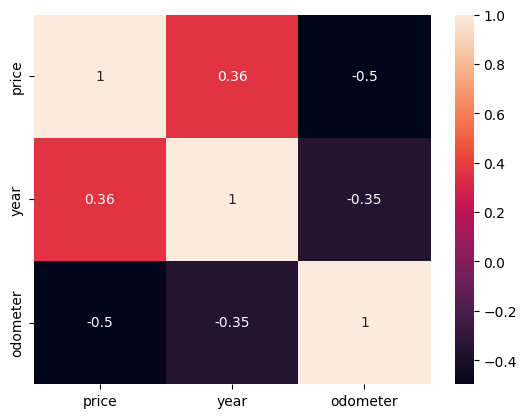

In [151]:
sns.heatmap(df_clean.corr(numeric_only=True), annot=True)

In [154]:
df_final = df_clean.dropna()
df_final.isna().sum()

,0
price,0
year,0
manufacturer,0
model,0
condition,0
cylinders,0
fuel,0
odometer,0
title_status,0
transmission,0


In [50]:
# With data cleanup done we can move to modelling stage

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [155]:
# Lets get value count of all features
for col in df_final.columns:
    print(f"{col}: {df_final[col].value_counts()}")

price: price
4500     1383
3500     1354
6500     1346
29990    1323
5500     1309
         ... 
3625        1
14735       1
24025       1
23310       1
59998       1
Name: count, Length: 6064, dtype: int64
year: year
2013.0    10462
2017.0    10113
2014.0     9516
2015.0     8991
2016.0     8747
          ...  
1941.0       16
1948.0       13
2022.0        4
1942.0        3
1944.0        1
Name: count, Length: 81, dtype: int64
manufacturer: manufacturer
ford               23209
chevrolet          20370
toyota             12258
honda               7887
nissan              7196
jeep                6572
gmc                 6570
ram                 5450
dodge               4818
bmw                 4147
mercedes-benz       3857
lexus               3245
hyundai             3112
subaru              3086
volkswagen          2899
chrysler            2493
audi                2471
kia                 2320
acura               2304
infiniti            2293
cadillac            2182
buick           

Looking at the value_counts of diffferent featuresm we can drop following features:

1. type has minimal impact on price
2. Mainly automatic transmission, so drop
3. Ford has most number of vehicles, and with many maufacturers we can drop this as well
4. Too many models and so drop
5. Droping cylinders as it has minimal impact on price
6. Mostly clean title - drop



In [156]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140242 entries, 27 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         140242 non-null  int64  
 1   year          140242 non-null  float64
 2   manufacturer  140242 non-null  object 
 3   model         140242 non-null  object 
 4   condition     140242 non-null  object 
 5   cylinders     140242 non-null  object 
 6   fuel          140242 non-null  object 
 7   odometer      140242 non-null  float64
 8   title_status  140242 non-null  object 
 9   transmission  140242 non-null  object 
 10  type          140242 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 12.8+ MB


In [158]:
# Create category variables

df_category = pd.get_dummies(df_final.drop(
    ['type', 'transmission', 'manufacturer', 'model', 'cylinders', 'title_status'], axis=1),
    columns=["condition","fuel"])
df_category.head()


,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
27,33590,2014.0,57923.0,False,False,True,False,False,False,False,False,True,False,False
28,22590,2010.0,71229.0,False,False,True,False,False,False,False,False,True,False,False
29,39590,2020.0,19160.0,False,False,True,False,False,False,False,False,True,False,False
30,30990,2017.0,41124.0,False,False,True,False,False,False,False,False,True,False,False
31,15000,2013.0,128000.0,True,False,False,False,False,False,False,False,True,False,False


In [159]:
#Lets look at correlation between these variables to see if there are any highly correlated features
df_category.corr()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other
price,1.000000,0.400303,-0.591281,-0.147717,-0.165714,0.173622,0.043570,0.051186,-0.045369,0.202106,0.016387,-0.219134,-0.037783,0.139597
year,0.400303,1.000000,-0.354605,-0.028835,-0.213702,0.061628,0.064153,0.026316,-0.035336,-0.020166,0.021442,-0.045885,0.021405,0.091299
odometer,-0.591281,-0.354605,1.000000,0.121829,0.173009,-0.123115,-0.088094,-0.046488,0.034218,0.101536,-0.027647,-0.013984,0.023177,-0.125117
condition_excellent,-0.147717,-0.028835,0.121829,1.000000,-0.145323,-0.762705,-0.281605,-0.054206,-0.040634,0.028744,-0.001643,0.031267,0.033346,-0.119925
condition_fair,-0.165714,-0.213702,0.173009,-0.145323,1.000000,-0.154485,-0.057039,-0.010979,-0.008230,0.001737,-0.005702,0.017789,-0.010976,-0.025727
condition_good,0.173622,0.061628,-0.123115,-0.762705,-0.154485,1.000000,-0.299358,-0.057624,-0.043196,-0.033086,-0.009463,-0.045405,-0.037042,0.157236
condition_like new,0.043570,0.064153,-0.088094,-0.281605,-0.057039,-0.299358,1.000000,-0.021276,-0.015949,0.006386,0.020632,0.013040,0.011809,-0.046301
condition_new,0.051186,0.026316,-0.046488,-0.054206,-0.010979,-0.057624,-0.021276,1.000000,-0.003070,0.002260,0.003136,0.001402,0.002735,-0.008433
condition_salvage,-0.045369,-0.035336,0.034218,-0.040634,-0.008230,-0.043196,-0.015949,-0.003070,1.000000,-0.001447,0.001876,0.004167,0.001956,-0.007431
fuel_diesel,0.202106,-0.020166,0.101536,0.028744,0.001737,-0.033086,0.006386,0.002260,-0.001447,1.000000,-0.008757,-0.736192,-0.023599,-0.034299


Correlation reveals that price is
1. Highly correlated with fuel type diesel,
2. Additionally positive correlation with year, condition like new , condition new , fuel electric, size_full_size, drive_4wd and drive_rwd.
3. All other correlations are negative
4. Fuel diesel and fuel gas are high negative correlation

Analysis of correlation matrix shows the correlation of price with drive, fuel type,

In [56]:
# Lets work on the model now that we are clear on most items and data if fully clean
X = df_category.drop(['price'], axis=1)
y = df_category.price

In [57]:
# Lets split in train and test sets 80/20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [58]:
# Lets create a LinearRegression model
model = LinearRegression()
#Lets train the model
model.fit(X_train, y_train)
model.coef_

array([ 3.45869701e+02, -1.02020155e-01,  8.38435776e+02, -1.21319575e+03,
        2.57085325e+01,  1.81276186e+03,  5.93187541e+03, -7.39558583e+03,
        1.26677194e+04, -1.80273162e+03, -3.58308565e+03, -2.30333078e+03,
       -4.97857138e+03, -1.83366082e+03,  3.13269695e+03, -4.48556157e+02,
       -8.50479973e+02,  3.37211935e+03, -5.28848327e+03,  1.91636392e+03])

In [59]:
model.intercept_

np.float64(-667437.1868082681)

In [60]:
#Let compute the predictions for the training data
predictions_train=model.predict(X_train)
predictions_train

array([25530.61551056, 17665.66784196, 17959.78348668, ...,
       24157.09021469, 20113.88178317, 34601.98396341])

In [61]:
# Lets get the model accuracy for this
score = model.score(X_train, y_train)
accuracy = score * 100
root_mean_squared_error = np.sqrt(mean_squared_error(y_train, predictions_train))
print("Accuracy Train: ", accuracy)
print("RMSE Train:     ",root_mean_squared_error)

Accuracy Train:  60.15686878385009
RMSE Train:      8026.0727452788515


In [62]:
# The accuracy of the linear regression model is 0.60, which is not great

In [63]:
# Lets try accuracy on the test set
predictions_test=model.predict(X_test)

In [64]:
# Lets get the model accuracy for this
score = model.score(X_test, y_test)
accuracy = score * 100
root_mean_squared_error = np.sqrt(mean_squared_error(y_test, predictions_test))
print("Accuracy Test: ", accuracy)
print("RMSE Test:     ",root_mean_squared_error)

Accuracy Test:  59.007393117285226
RMSE Test:      8257.967336354186


In [65]:
# The test and train accuracy is similar , This shows that the linear regression model is not an overfit.

Text(0.5, 1.0, 'Linear Regression Results - Year against Price')

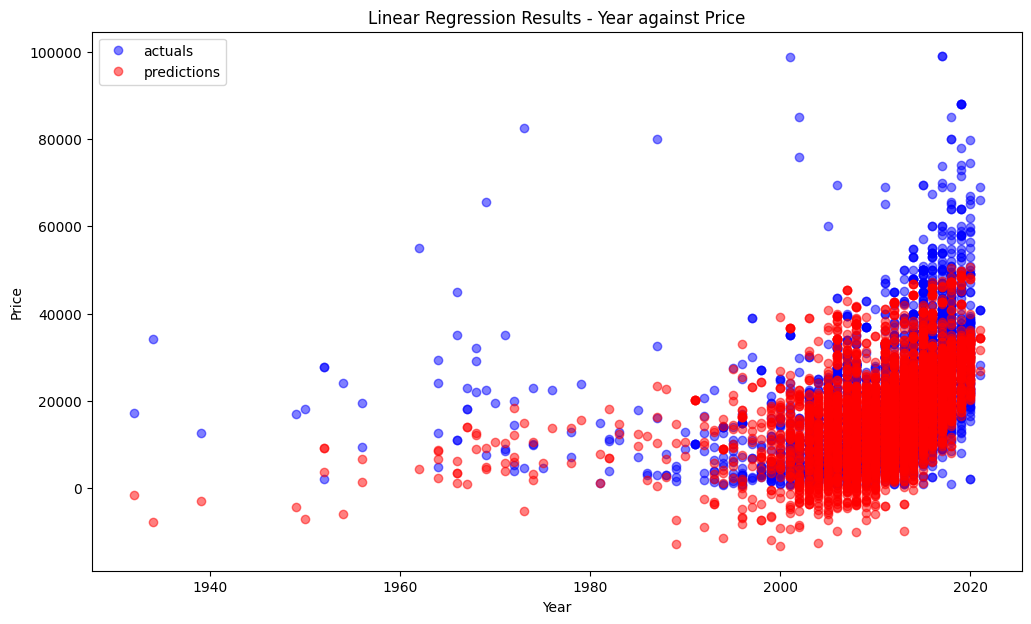

In [66]:
# Lets plot the actual and predicted values of price vs year, lets use two colors for the actual and predicted price
fig, axes = plt.subplots(1, 1, figsize =(12, 7))
axes.plot (X_test.year, y_test, 'ob', label ='actuals', alpha=0.5)
axes.plot (X_test.year, predictions_test, 'or', label ='predictions', alpha=0.5)
axes.set(xlabel='Year', ylabel='Price')
axes.legend()
axes.set_title('Linear Regression Results - Year against Price')


In [67]:
np.corrcoef(y_test, predictions_test) [0][1]

np.float64(0.7681682168665293)

Correlation is 0.77 and accuracy is 60.79. So the simple linear regression model is not good enough to predict the price given the features of the car. So lets try other models

Now that we have used simple regression model with these features to predict price, we have found that the models predictions are not of very high quality.

In [68]:
df_category.head()

,price,year,odometer,condition_excellent,condition_fair,condition_good,condition_like new,condition_new,condition_salvage,fuel_diesel,...,fuel_gas,fuel_hybrid,fuel_other,size_compact,size_full-size,size_mid-size,size_sub-compact,drive_4wd,drive_fwd,drive_rwd
215,4000,2002,155000.0,True,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,True,False
219,2500,1995,110661.0,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,True
268,9000,2008,56700.0,True,False,False,False,False,False,False,...,True,False,False,True,False,False,False,False,False,True
337,8950,2011,164000.0,True,False,False,False,False,False,False,...,True,False,False,False,True,False,False,False,True,False
338,4000,1972,88100.0,False,True,False,False,False,False,False,...,True,False,False,False,True,False,False,False,False,True


In [69]:
# Lets create a model with only odometer and year as fetures and use different degrees to find the best model fit
X = df_category[['odometer', 'year']]
y = df_category.price
# Lets get train and test data sets
X1_train, X1_test, y1_train, y1_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# Lets build models with different degrees and loop , lets use degree 1 to 5
train1_mses = []
test1_mses = []
best_complexity = ''
for i in range(1, 6):
    pipe = Pipeline([('poly', PolynomialFeatures(degree = i, include_bias=False)),
                    ('linreg', LinearRegression())])
    pipe.fit(X1_train, y1_train)
    train1_mses.append(mean_squared_error(y1_train, pipe.predict(X1_train)))
    test1_mses.append(mean_squared_error(y1_test, pipe.predict(X1_test)))

best_complexity = np.argmin(test1_mses)

print(f'The Complexity that minimized Test Error was: {best_complexity}')
print(f'The minimal MSE was: {min(test1_mses)}')

The Complexity that minimized Test Error was: 3
The minimal MSE was: 112928409.06815098


The best complexity is found to be 3

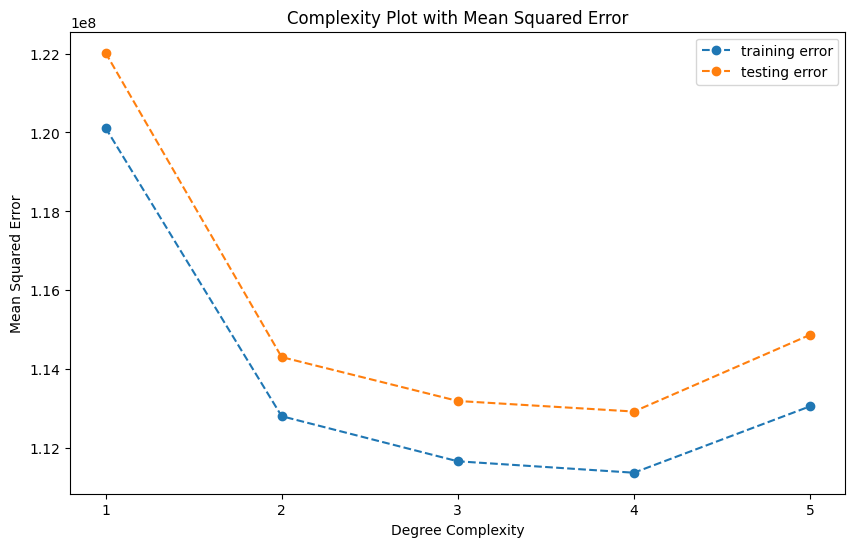

In [70]:
# Lets Visualize these results
plt.figure(figsize =(10, 6))
plt.title('Complexity Plot with Mean Squared Error')
plt.plot(range(1, 6), train1_mses, '--o', label = 'training error')
plt.plot(range(1, 6), test1_mses, '--o', label = 'testing error')
plt.xticks(range(1, 6), range(1, 6))
plt.xlabel('Degree Complexity')
plt.ylabel('Mean Squared Error')
plt.legend();

In [167]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140242 entries, 27 to 426878
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   price         140242 non-null  int64  
 1   year          140242 non-null  float64
 2   manufacturer  140242 non-null  object 
 3   model         140242 non-null  object 
 4   condition     140242 non-null  object 
 5   cylinders     140242 non-null  object 
 6   fuel          140242 non-null  object 
 7   odometer      140242 non-null  float64
 8   title_status  140242 non-null  object 
 9   transmission  140242 non-null  object 
 10  type          140242 non-null  object 
dtypes: float64(2), int64(1), object(8)
memory usage: 12.8+ MB


In [173]:
#Lets use other models to do feature selections and predict price

df = df_final.copy()
X = df[['year', 'odometer', 'condition', 'fuel']]
y = df['price']
# Lets define numerical and categorical features
numerical_features = ['year', 'odometer']
categorical_features = ['condition', 'fuel']
# Lets Split the data
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X, y, test_size=0.2, random_state=42)

# Lets make feature engineering and encoding pipelike-
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numerical_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Lasso with CV

lasso = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", LassoCV(alphas=np.logspace(-2,2,20), cv=3))
])
lasso.fit(X_train_lasso, y_train_lasso)
y_prediction_lsso = lasso.predict(X_test_lasso)
print("LASSO: MAE", mean_absolute_error(y_test_lasso, y_prediction_lsso),
      "| RMSE", mean_squared_error(y_test_lasso, y_prediction_lsso),
      "| R^2", r2_score(y_test_lasso, y_prediction_lsso))

# Get feature names after preprocessing
feature_names = lasso.named_steps['preprocessor'].get_feature_names_out()

# Get the coefficients from the trained Lasso model
coefficients = lasso.named_steps['regressor'].coef_

# Create a DataFrame to view the coefficients easily
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coefficients_df = coefficients_df.sort_values(by='Coefficient', ascending=False)

# Print features with non-zero coefficients
print("Features with non-zero coefficients (selected features):")
print(coefficients_df[coefficients_df['Coefficient'] != 0].to_string())

LASSO: MAE 7164.729362530489 | RMSE 100008087.24462922 | R^2 0.47443855181337746
Features with non-zero coefficients (selected features):
                     Feature   Coefficient
8           cat__fuel_diesel  16183.729890
6         cat__condition_new   3664.404720
12           cat__fuel_other   3422.009815
0                  num__year   2818.813288
4        cat__condition_good    867.704998
9         cat__fuel_electric     11.979342
10             cat__fuel_gas  -1101.204310
5    cat__condition_like new  -1289.989363
2   cat__condition_excellent  -1902.186523
3        cat__condition_fair  -3218.393571
11          cat__fuel_hybrid  -3677.872941
7     cat__condition_salvage  -6157.045051
1              num__odometer  -7220.622394


In [ ]:
#Fuel, Condition and year are the top three features to predict the price of vehicle

In [178]:
# Lets now create a sequential feature selection model as well
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression

# Apply the preprocessor to the training data
X_train_processed = preprocessor.transform(X_train_lasso)

# Use Linear Regression with SFS on processed data
sfs = SFS(LinearRegression(),
          k_features=3,
          forward=True,
          floating=False,
          scoring='r2',
          cv=0)
sfs.fit(X_train_processed, y_train_lasso)
print("Selected subset feature indices:", sfs.k_feature_idx_)
#Convert slectected feature indices to names
selected_feature_names = preprocessor.get_feature_names_out()[list(sfs.k_feature_idx_)]
print("Selected subset feature names:", selected_feature_names)
#y_prediction_lsso = sfs.predict(X_test_lasso)
#print("SFS: MAE", mean_absolute_error(y_test_lasso, y_prediction_lsso),
#      "| RMSE", mean_squared_error(y_test_lasso, y_prediction_lsso),
#      "| R^2", r2_score(y_test_lasso, y_prediction_lsso))

Selected subset feature indices: (0, 1, 8)
Selected subset feature names: ['num__year' 'num__odometer' 'cat__fuel_diesel']


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Data Quality and Preparation Observations

The dataset presented several quality issues that impacted the analysis. Notably, there were missing values and unrealistic entries — for example, prices listed as $0 and odometer readings of 0, which are not plausible for used cars.

Given the variability in features like fuel type, vehicle condition, size, type, and color, a more sophisticated imputation strategy would be required to realistically estimate missing or incorrect values. However, for the scope of this analysis, we chose to remove records with such inconsistencies to maintain data integrity.

Additionally, we dropped features such as ID, VIN, State, Manufacturer,  Model etc as they were either identifiers or showed minimal influence on predicting used car prices.

Which features are most important
it was found that the top most important features impacting price Diesel Fuel, Year and Odometer respectively

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

Based on the findings, the following recommendations are the recommendation used car dealers:

Prioritize newer models: Cars from more recent years command higher prices. Stocking a good selection of newer models should be a priority.

Highlight low mileage: Customers value low mileage. Marketing materials and pricing strategies should emphasize this key feature.

Highlight Diesel Car: As the buyers of old cars are preferring diesel as fuel type, so highlight that as well

Consider all features: While some features have a greater impact, the model demonstrates that a car's paint_color and type still hold predictive power.

